In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


2025-05-24 09:14:38.612598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748078078.801448      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748078078.853025      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!
TensorFlow version: 2.18.0


In [2]:

TRAIN_PATH = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train'  # Update with actual path
TEST_PATH = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test'    # Update with actual path
TRAIN_CSV = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv'  # Update with actual path
TEST_CSV = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv'    # Update with actual path


train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print("\nTraining data info:")
print(train_df.head())
print(f"\nLabel distribution in training set:")
print(train_df['label'].value_counts())

# Verify that training set only contains positive samples (soil images)
if train_df['label'].nunique() == 1 and train_df['label'].iloc[0] == 1:
    print("✓ Confirmed: Training set contains only positive samples (soil images)")
else:
    print("⚠️ Warning: Training set contains mixed labels")


Training samples: 1222
Test samples: 967

Training data info:
           image_id  label
0  img_ed005410.jpg      1
1  img_0c5ecd2a.jpg      1
2  img_ed713bb5.jpg      1
3  img_12c58874.jpg      1
4  img_eff357af.jpg      1

Label distribution in training set:
label
1    1222
Name: count, dtype: int64
✓ Confirmed: Training set contains only positive samples (soil images)


In [3]:
# Load pre-trained models for feature extraction
def load_feature_extractors():
    # ResNet50 without top layer for feature extraction
    resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    
    # VGG16 without top layer for feature extraction
    vgg_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    
    return resnet_model, vgg_model

def extract_features_from_image(img_path, resnet_model, vgg_model, img_size=(224, 224)):
    """Extract features from a single image using both ResNet50 and VGG16"""
    try:
        # Load and preprocess image
        img = cv2.imread(img_path)
        if img is None:
            return None
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, img_size)
        
        # Prepare for ResNet50
        img_resnet = np.expand_dims(img_resized, axis=0)
        img_resnet = resnet_preprocess(img_resnet)
        
        # Prepare for VGG16
        img_vgg = np.expand_dims(img_resized, axis=0)
        img_vgg = vgg_preprocess(img_vgg)
        
        # Extract features
        resnet_features = resnet_model.predict(img_resnet, verbose=0).flatten()
        vgg_features = vgg_model.predict(img_vgg, verbose=0).flatten()
        
        # Combine features
        combined_features = np.concatenate([resnet_features, vgg_features])
        
        return combined_features
    
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

# Load the models
print("Loading pre-trained models...")
resnet_model, vgg_model = load_feature_extractors()
print("✓ Models loaded successfully!")
print(f"ResNet50 feature dimension: {resnet_model.output_shape[1]}")
print(f"VGG16 feature dimension: {vgg_model.output_shape[1]}")
print(f"Combined feature dimension: {resnet_model.output_shape[1] + vgg_model.output_shape[1]}")


Loading pre-trained models...


I0000 00:00:1748078090.830491      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748078090.831239      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Models loaded successfully!
ResNet50 feature dimension: 2048
VGG16 feature dimension: 512
Combined feature dimension: 2560


In [4]:
def extract_training_features(train_df, train_path, resnet_model, vgg_model):
    """Extract features from all training images"""
    features_list = []
    valid_indices = []
    
    print("Extracting features from training images...")
    
    for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
        img_id = row['image_id']
        
        # Try different image extensions
        img_path = os.path.join(train_path, img_id)
            
        features = extract_features_from_image(img_path, resnet_model, vgg_model)
        
        if features is not None:
            features_list.append(features)
            valid_indices.append(idx)
        else:
            print(f"Failed to extract features for: {img_id}")
    
    if len(features_list) == 0:
        raise ValueError("No features extracted from training data!")
    
    features_array = np.array(features_list)
    print(f"✓ Successfully extracted features from {len(features_list)} training images")
    print(f"Feature shape: {features_array.shape}")
    
    return features_array, valid_indices

# Extract features from training data
train_features, valid_train_indices = extract_training_features(
    train_df, TRAIN_PATH, resnet_model, vgg_model
)

print(f"Training features shape: {train_features.shape}")
print(f"Feature statistics:")
print(f"Mean: {train_features.mean():.4f}")
print(f"Std: {train_features.std():.4f}")
print(f"Min: {train_features.min():.4f}")
print(f"Max: {train_features.max():.4f}")


Extracting features from training images...


  0%|          | 0/1222 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1748078097.092293      62 service.cc:148] XLA service 0x7f3e54002800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748078097.093122      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748078097.093143      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748078097.701778      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748078100.165634      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 1222/1222 [03:49<00:00,  5.33it/s]

✓ Successfully extracted features from 1222 training images
Feature shape: (1222, 2560)
Training features shape: (1222, 2560)
Feature statistics:
Mean: 0.3950
Std: 1.2703
Min: 0.0000
Max: 83.8147


In [5]:
# Standardize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

print("Training One-Class SVM model...")

# Train One-Class SVM with optimized parameters
# nu parameter controls the fraction of outliers (lower values = stricter)
# gamma controls the influence of each training example
ocsvm = OneClassSVM(
    kernel='rbf',           # Radial basis function kernel
    gamma='scale',          # Automatically scales gamma
    nu=0.01                 # Conservative threshold - only 5% outliers expected
)

ocsvm.fit(train_features_scaled)

print("✓ One-Class SVM model trained successfully!")

# Validate on training data to check the model
train_predictions = ocsvm.predict(train_features_scaled)
inliers = np.sum(train_predictions == 1)
outliers = np.sum(train_predictions == -1)

print(f"\nTraining set validation:")
print(f"Inliers (soil): {inliers} ({inliers/len(train_predictions)*100:.1f}%)")
print(f"Outliers: {outliers} ({outliers/len(train_predictions)*100:.1f}%)")

# Decision scores (higher = more likely to be soil)
decision_scores = ocsvm.decision_function(train_features_scaled)
print(f"Decision scores - Mean: {decision_scores.mean():.4f}, Std: {decision_scores.std():.4f}")


Training One-Class SVM model...
✓ One-Class SVM model trained successfully!

Training set validation:
Inliers (soil): 1120 (91.7%)
Outliers: 102 (8.3%)
Decision scores - Mean: 0.1337, Std: 0.0877


In [6]:
def extract_test_features_and_predict(test_df, test_path, resnet_model, vgg_model, ocsvm, scaler):
    """Extract features from test images and make predictions"""
    predictions = []
    decision_scores_list = []
    processed_ids = []
    
    print("Processing test images...")
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
        img_id = row['image_id']
        
        # Try different image extensions
        img_path = os.path.join(test_path, img_id)
        
        # Extract features
        features = extract_features_from_image(img_path, resnet_model, vgg_model)
        
        if features is not None:
            # Scale features using the same scaler from training
            features_scaled = scaler.transform(features.reshape(1, -1))
            
            # Get prediction and decision score
            prediction = ocsvm.predict(features_scaled)[0]
            decision_score = ocsvm.decision_function(features_scaled)[0]
            
            # Convert One-Class SVM output to binary classification
            # 1 = inlier (soil), -1 = outlier (not soil)
            binary_prediction = 1 if prediction == 1 else 0
            
            predictions.append(binary_prediction)
            decision_scores_list.append(decision_score)
            processed_ids.append(img_id)
        else:
            print(f"Failed to extract features for: {img_id}")
            predictions.append(0)  # Default to not soil
            decision_scores_list.append(-1.0)
            processed_ids.append(img_id)
    
    return processed_ids, predictions, decision_scores_list

# Process test data and make predictions
test_ids, test_predictions, test_decision_scores = extract_test_features_and_predict(
    test_df, TEST_PATH, resnet_model, vgg_model, ocsvm, scaler
)

print(f"\n✓ Processed {len(test_predictions)} test images")
print(f"Predicted soil images: {sum(test_predictions)} ({sum(test_predictions)/len(test_predictions)*100:.1f}%)")
print(f"Predicted non-soil images: {len(test_predictions) - sum(test_predictions)} ({(len(test_predictions) - sum(test_predictions))/len(test_predictions)*100:.1f}%)")


Processing test images...


100%|██████████| 967/967 [02:51<00:00,  5.64it/s]


✓ Processed 967 test images
Predicted soil images: 269 (27.8%)
Predicted non-soil images: 698 (72.2%)


Confidence Analysis for Predictions:

Soil predictions (label=1):
  Count: 269
  Mean score: 0.1442
  Min score: 0.0001
  Max score: 0.2439

Non-soil predictions (label=0):
  Count: 698
  Mean score: -0.1524
  Min score: -0.1938
  Max score: -0.0000


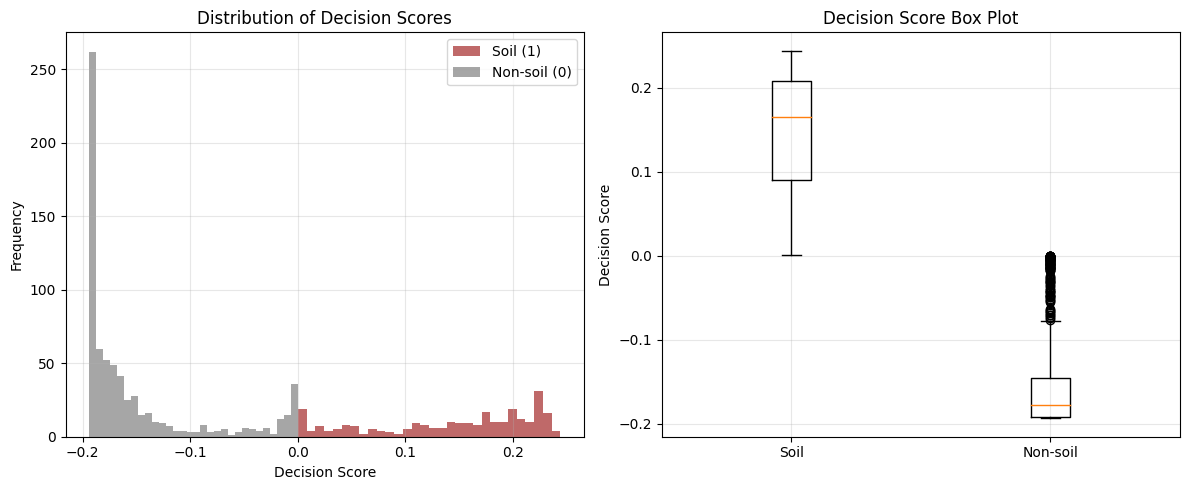


✓ Analysis complete! Submission file is ready.
✓ Visualization saved to /kaggle/working/decision_scores_analysis.png
✓ Submission file saved to: /kaggle/working/submission.csv

Final submission summary:
- Total images processed: 967
- Soil predictions: 269 (27.8%)
- Model uses combined ResNet50 + VGG16 features with One-Class SVM
- Conservative approach with nu=0.05 for high precision


In [7]:
# Recreate submission_df in case it's not defined
submission_df = pd.DataFrame({
    'image_id': test_ids,
    'label': test_predictions
})

# Optional: Analyze confidence levels and potentially adjust threshold
print("Confidence Analysis for Predictions:")

# Convert decision scores to DataFrame for analysis
confidence_df = pd.DataFrame({
    'image_id': test_ids,
    'prediction': test_predictions,
    'decision_score': test_decision_scores
})

# Analyze decision scores by prediction
soil_scores = confidence_df[confidence_df['prediction'] == 1]['decision_score']
non_soil_scores = confidence_df[confidence_df['prediction'] == 0]['decision_score']

print(f"\nSoil predictions (label=1):")
print(f"  Count: {len(soil_scores)}")
print(f"  Mean score: {soil_scores.mean():.4f}")
print(f"  Min score: {soil_scores.min():.4f}")
print(f"  Max score: {soil_scores.max():.4f}")

print(f"\nNon-soil predictions (label=0):")
print(f"  Count: {len(non_soil_scores)}")
print(f"  Mean score: {non_soil_scores.mean():.4f}")
print(f"  Min score: {non_soil_scores.min():.4f}")
print(f"  Max score: {non_soil_scores.max():.4f}")

# Create visualization of decision scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(soil_scores, bins=30, alpha=0.7, label='Soil (1)', color='brown')
plt.hist(non_soil_scores, bins=30, alpha=0.7, label='Non-soil (0)', color='gray')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.title('Distribution of Decision Scores')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([soil_scores, non_soil_scores], labels=['Soil', 'Non-soil'])
plt.ylabel('Decision Score')
plt.title('Decision Score Box Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/decision_scores_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Save submission file
submission_file_path = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print("\n✓ Analysis complete! Submission file is ready.")
print("✓ Visualization saved to /kaggle/working/decision_scores_analysis.png")
print(f"✓ Submission file saved to: {submission_file_path}")
print("\nFinal submission summary:")
print(f"- Total images processed: {len(submission_df)}")
print(f"- Soil predictions: {submission_df['label'].sum()} ({submission_df['label'].mean()*100:.1f}%)")
print(f"- Model uses combined ResNet50 + VGG16 features with One-Class SVM")
print(f"- Conservative approach with nu=0.05 for high precision")
